In [0]:
!git clone https://github.com/andriygav/MixtureLib.git
!python3 -m pip install MixtureLib/src/.

from mixturelib.local_models import EachModelLinear
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet
from mixturelib.mixture import MixtureEM

import matplotlib.pyplot as plt
from matplotlib import gridspec
import pylab

from tqdm import tqdm_notebook as tqdm
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

fatal: destination path 'MixtureLib' already exists and is not an empty directory.
Processing ./MixtureLib/src
  Created wheel for mixturelib: filename=mixturelib-0.2.2-cp36-none-any.whl size=13362 sha256=04c7d7488cc1be0cfae39d056e69881f42a4f25965df27f1b57a3a94aed7ee52
  Stored in directory: /tmp/pip-ephem-wheel-cache-jmf5txji/wheels/8f/0e/0e/7b633cbf34c93d96d5b40677655ae6cda78087b2231b3cb1dc
Successfully built mixturelib
  Found existing installation: mixturelib 0.2.2
    Uninstalling mixturelib-0.2.2:
      Successfully uninstalled mixturelib-0.2.2


device(type='cpu')

In [0]:
def f_1(x):
    return 10*x[0] + np.random.randn()

def f_2(x):
    return 30*x[0] + np.random.randn()

def cor_Pearson(a, b):
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    first_sum = 0
    second_sum = 0
    third_sum = 0
    for i in range(len(a)):
        first_sum += (float(a[i]) - float(a_mean))*(float(b[i]) - float(b_mean))
        second_sum += (float(a[i]) - float(a_mean))**2
        third_sum += (float(b[i]) - float(b_mean))**2
    return first_sum/(second_sum*third_sum)**(0.5)

N = 200
n = 2
nn = 200

errors = []
correlations = []
sigmas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.11,0.12, 0.13, 0.14,0.15, 0.22, 0.27, 0.32, 0.37, 0.42, 0.47, 0.52, 0.57, 0.62, 0.67, 0.72, 0.77, 0.82, 0.87, 0.92, 0.97]

In [0]:
torch.random.manual_seed(42)
first_model = EachModelLinear(input_dim=2)
second_model = EachModelLinear(input_dim=2)

list_of_models = [first_model, second_model]

In [0]:
HpMd = HyperExpertNN(input_dim=2, hidden_dim=5,output_dim=2, epochs=1000)

In [0]:
mixture = MixtureEM(HyperParameters={'beta': 1.},
                    HyperModel=HpMd,
                    ListOfModels=list_of_models,
                    model_type='sample')

In [0]:
i = 0
for sigma in sigmas:
    #---------------data----------------------------
    x1 = np.random.normal(0, 1, 200).reshape((200, 1))
    x2 = np.random.normal(0, 1, 200).reshape((200, 1))
    y1 = np.array([f_1(x) for x in x1])
    y2 = np.array([f_2(x) for x in x2])

    mu = 0
    #sigmas.append(sigma)
    s1 = np.random.normal(mu, sigma, 200).reshape((200, 1))
    s2 = np.random.normal(mu, sigma, 200).reshape((200, 1))
    X1 = np.hstack([x1, s1]) 
    X2 = np.hstack([s2, x2])

    X = np.vstack([X1, X2])
    Y = np.hstack([y1, y2])

    real_second_w = np.array([[10.], [0.]])
    real_first_w = np.array([[0.], [30.]])

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    #-------------------ensemble of model----------------
    torch.random.manual_seed(42)
    mixture.fit(X_tr, Y_tr)
    predicted_first_w = mixture.ListOfModels[0].W.numpy()
    predicted_second_w = mixture.ListOfModels[1].W.numpy()
    weights = []
    weights.append([predicted_first_w[0][0], predicted_first_w[1][0]])
    weights.append([predicted_second_w[0][0], predicted_second_w[1][0]])
    #----------distance between local models---------------
    Y1 = X.dot(weights[0])
    Y2 = X.dot(weights[1])
    correlations.append(cor_Pearson(Y1, Y2))
    pi = mixture.HyperModel.PredictPi(X_tr, None)
    er = torch.cat([pi[:, k].view([-1,1])*(Y_tr - local_model(X_tr))**2 for k, local_model in enumerate(mixture.ListOfModels)], dim=1).sum()
    errors1.append(float(er))
    print(sigmas[i], cor_Pearson(Y1, Y2), float(er))
    i+=1


0.0 0.9999992968936404 423.3213195800781
0.1 0.9979119083711261 2508.3916015625
0.2 0.9996962757096163 7496.84375
0.3 0.9975537513836797 16349.0224609375
0.4 0.9993924129126459 30763.615234375
0.5 0.9430551350819782 44545.3828125
0.6 0.34107181999885483 98627.3515625
0.7 -0.0925785622173881 120254.4609375
0.8 0.11747095886458782 146409.84375
0.9 0.02210384381310492 197375.5625
1.0 -0.05204933565333183 194650.5625
0.03 0.99999991912687 495.94842529296875
0.04 0.9999851180778471 743.15087890625
0.05 0.9999981151441296 917.0643310546875
0.06 0.9999714794944122 1174.82470703125
0.07 0.9999971375333523 1332.3853759765625
0.08 0.9998750150723738 1756.830810546875
0.09 0.999965175832419 1815.8707275390625
0.15 0.9998638631307403 4674.986328125
0.25 0.9993572719910956 11272.634765625
0.35 0.997236779762471 22826.9609375
0.45 0.9977220154951464 33412.25
0.55 0.9995535844452185 49428.8203125
0.65 0.9904459153686936 61541.421875
0.75 0.9996707261515307 79703.9765625
0.85 0.2460478292621621 94181.

[0.9999992968936404,
 0.9979119083711261,
 0.9996962757096163,
 0.9975537513836797,
 0.9993924129126459,
 0.9430551350819782,
 0.34107181999885483,
 -0.0925785622173881,
 0.11747095886458782,
 0.02210384381310492,
 -0.05204933565333183,
 0.99999991912687,
 0.9999851180778471,
 0.9999981151441296,
 0.9999714794944122,
 0.9999971375333523,
 0.9998750150723738,
 0.999965175832419,
 0.9998638631307403,
 0.9993572719910956,
 0.997236779762471,
 0.9977220154951464,
 0.9995535844452185,
 0.9904459153686936,
 0.9996707261515307,
 0.2460478292621621,
 -0.09508020767666715,
 0.22827293699528892,
 0.21279917865507622,
 0.07063012107817072,
 0.39469171998292435,
 0.12452612097746787,
 -0.010754215566856856,
 0.08474800557386238,
 0.04125134873415941,
 0.10364332322583364,
 -0.09876911643409719,
 -0.031434248477696596,
 -0.015990656379527395,
 -0.07912131070187844,
 -0.0023336871025006036,
 -0.03509245603798999,
 0.10113580015986923,
 0.03134462815043313,
 -0.07205254115783725,
 0.00213513531585446

No handles with labels found to put in legend.


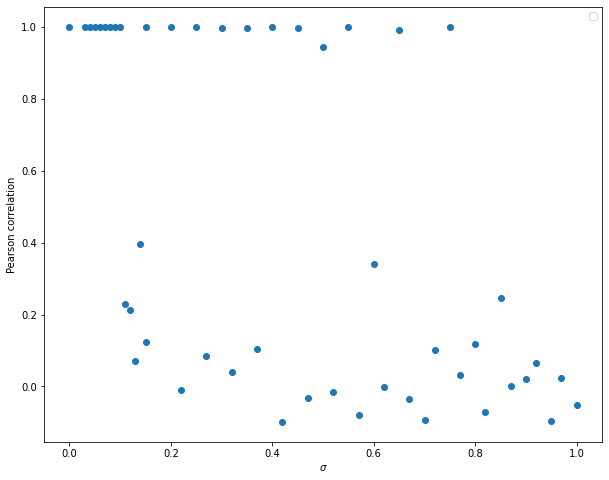

In [0]:
fig = plt.figure(figsize=(10,8))   
plt.scatter(sigmas, correlations)  

# После нанесения графического элемента в виде маркера
# список текущих областей состоит из одной области
print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Pearson correlation')
# смотри преамбулу


pylab.savefig('Pearson_cor_sigma.pdf')
plt.show()

ValueError: ignored

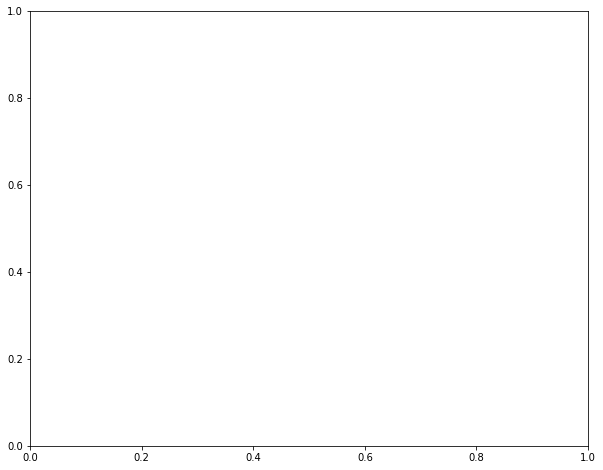

In [0]:
fig = plt.figure(figsize=(10,8))   
plt.scatter(sigmas, errors)  

# После нанесения графического элемента в виде маркера
# список текущих областей состоит из одной области
print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Pearson correlation')
# смотри преамбулу


pylab.savefig('Pearson_cor_sigma.pdf')
plt.show()

In [0]:
correlations

[0.9999992968936404,
 0.9979119083711261,
 0.9996962757096163,
 0.9975537513836797,
 0.9993924129126459,
 0.9430551350819782,
 0.34107181999885483,
 -0.0925785622173881,
 0.11747095886458782,
 0.02210384381310492,
 -0.05204933565333183,
 0.99999991912687,
 0.9999851180778471,
 0.9999981151441296,
 0.9999714794944122,
 0.9999971375333523,
 0.9998750150723738,
 0.999965175832419,
 0.9998638631307403,
 0.9993572719910956,
 0.997236779762471,
 0.9977220154951464,
 0.9995535844452185,
 0.9904459153686936,
 0.9996707261515307,
 0.2460478292621621,
 -0.09508020767666715,
 0.22827293699528892,
 0.21279917865507622,
 0.07063012107817072,
 0.39469171998292435,
 0.12452612097746787,
 -0.010754215566856856,
 0.08474800557386238,
 0.04125134873415941,
 0.10364332322583364,
 -0.09876911643409719,
 -0.031434248477696596,
 -0.015990656379527395,
 -0.07912131070187844,
 -0.0023336871025006036,
 -0.03509245603798999,
 0.10113580015986923,
 0.03134462815043313,
 -0.07205254115783725,
 0.00213513531585446

In [0]:
torch.random.manual_seed(42)
first_model = EachModelLinear(input_dim=13)
second_model = EachModelLinear(input_dim=13)

list_of_models = [first_model, second_model]
HpMd = HyperExpertNN(input_dim=13, hidden_dim=5,output_dim=2, epochs=1000)
mixture = MixtureEM(HyperParameters={'beta': 1.},
                    HyperModel=HpMd,
                    ListOfModels=list_of_models,
                    model_type='sample')

In [0]:
#Boston
from sklearn.datasets import load_boston
import pandas as pd  
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
X_boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names).values
y_boston = boston['MEDV'] = boston_dataset.target
#Servo
def LoadData(url = "https://raw.githubusercontent.com/ttgadaev/SampleSizeEstimation/master/datasets/servo.csv",
             path = None):
    """
    return X, y
    """
    if path is not None:
        if os.path.exists(path):
            data = pd.read_csv(path, header=0)
        else:
            data = pd.read_csv(url, header=0)
            data.to_csv(path, header=True, index=False)
    else:
        data = pd.read_csv(url, header=0)

    y = data['answer'].values
    del data['answer']
    X = data.values
    return X, y

X_servo, y_servo = LoadData(url = "https://raw.githubusercontent.com/ttgadaev/SampleSizeEstimation/master/datasets/servo.csv")

X_servo[np.where(X_servo == 'A')] = 1
X_servo[np.where(X_servo == 'B')] = 2
X_servo[np.where(X_servo == 'C')] = 3
X_servo[np.where(X_servo == 'D')] = 4
X_servo[np.where(X_servo == 'E')] = 5
X_servo = np.array(X_servo, dtype = np.float64)



In [0]:
sigmas1 = []
correlations1 = []
errors1 = []

In [0]:
for i in range(0,50):
    #---------------data----------------------------
    mu, sigma = 0, i*0.01
    sigmas1.append(sigma)
    X1 = X_boston
    X1 = scale(X1)
    X2 = X_servo
    s = np.zeros((167, 9))
    for i in range(9):
        s[:,i] = np.random.normal(mu, sigma, 167)
    X2 = np.hstack([X2, s])
    X2 = scale(X2)
    X = np.vstack([X1, X2])
    Y = np.hstack([y_boston, y_servo])
    X = scale(X)
    Y = scale(Y)
    torch.random.manual_seed(42)
    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    #print(X_tr.shape, Y_tr.shape)
    #-------------------ensemble of model----------------
    torch.random.manual_seed(42)
    mixture.fit(X_tr, Y_tr)
    predict_1 = []
    predict_2 = []    
    for i in range(13):
        predict_1.append(mixture.ListOfModels[0].W[i][0])
    predict_1 = np.array(predict_1)
    for i in range(13):
        predict_2.append(mixture.ListOfModels[1].W[i][0])
    predict_2 = np.array(predict_2)
    print(predict_1)
    print(predict_2)
    #----------distance between local models---------------
    temp = []
    Y1 = X.dot(predict_1)
    Y2 = X.dot(predict_2)
    pi = mixture.HyperModel.PredictPi(X_tr, None)
    er = torch.cat([pi[:, k].view([-1,1])*(Y_tr - local_model(X_tr))**2 for k, local_model in enumerate(mixture.ListOfModels)], dim=1).sum()
    errors1.append(er)
    correlations1.append(cor_Pearson(Y1, Y2))
    print(sigma, cor_Pearson(Y1, Y2), er)


[ 0.10611154 -0.58206457 -0.06181131  0.09280529 -0.21381058 -0.02584783
 -0.04465687 -0.01514861  0.06202256 -0.00613502 -0.16680071  0.03275106
 -0.20426613]
[-0.82946676  0.2744738  -0.00951524  0.06315399  0.15740277  0.42899552
  0.02456234 -0.16730669  0.32174382 -0.17613754  0.03188369  0.10356209
 -0.39093974]
0.0 0.007540983886337561 tensor(244.6187, grad_fn=<SumBackward0>)


KeyboardInterrupt: ignored

In [0]:
er = int(torch.cat([pi[:, k].view([-1,1])*(Y_tr - local_model(X_tr))**2 for k, local_model in enumerate(mixture.ListOfModels)], dim=1).sum())
errors1.append(er)

In [0]:
[pi[:, k].view([-1,1])*(Y_tr - local_model(X_tr))**2 for k, local_model in enumerate(mixture.ListOfModels)]

[tensor([[2.0841e-04],
         [7.5058e-02],
         [3.1569e-02],
         [1.6805e-02],
         [4.3915e-02],
         [5.8716e-04],
         [6.4640e-06],
         [3.1193e-01],
         [3.9095e-02],
         [4.7321e-02],
         [1.0790e-01],
         [1.2966e-01],
         [1.9385e-02],
         [5.4718e-03],
         [2.4309e-02],
         [6.9866e-03],
         [8.4339e-03],
         [5.4106e-04],
         [5.9224e-02],
         [6.3694e-03],
         [4.4134e-03],
         [6.1106e-03],
         [2.7552e-04],
         [4.3073e-03],
         [2.0295e-02],
         [4.1714e-02],
         [1.9150e-02],
         [5.2265e-03],
         [1.2391e-03],
         [3.4795e-03],
         [3.2033e-03],
         [3.8985e-02],
         [1.7680e-01],
         [4.0437e-02],
         [1.8907e-03],
         [4.9067e-02],
         [4.8323e-03],
         [1.0278e-02],
         [4.9910e-02],
         [3.3062e-05],
         [7.8949e-06],
         [2.9004e-06],
         [6.6817e-03],
         [4

No handles with labels found to put in legend.


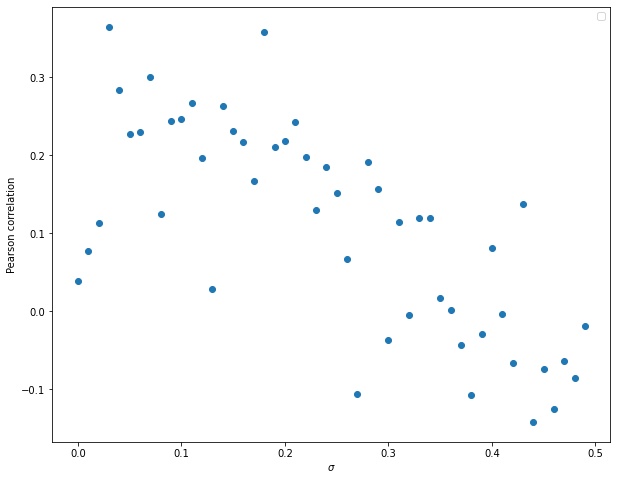

In [0]:
fig = plt.figure(figsize=(10,8))   

plt.scatter(sigmas1, correlations1)  

# После нанесения графического элемента в виде маркера
# список текущих областей состоит из одной области
print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Pearson correlation')
# смотри преамбулу


pylab.savefig('Pearson_cor_sigma_for_servo_and_boston.pdf')
plt.show()

No handles with labels found to put in legend.


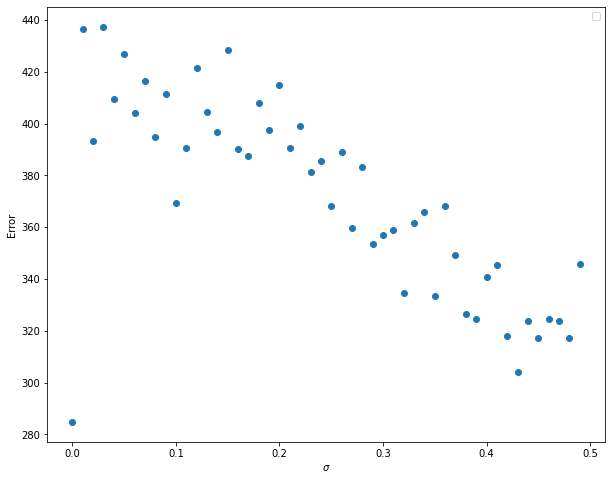

In [0]:
fig = plt.figure(figsize=(10,8))

for i in range(len(errors1)):
    errors1[i] = (float(errors1[i]))
plt.scatter(sigmas1, errors1)  
# После нанесения графического элемента в виде маркера
# список текущих областей состоит из одной области
print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Error')
# смотри преамбулу


pylab.savefig('Errors_sigma_boston_and_servo.pdf')
plt.show()

In [0]:
float(errors1[0])

284.7788391113281

In [0]:
X.shape

(673, 13)

In [0]:
sigmas1

[0.0]